In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torchvision.models as models
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)


In [2]:
from PIL import Image
import torch
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)

def compute_gradient(func, inp, **kwargs):
    '''Computes the gradient with respect to input image'''

    inp.requires_grad = True

    loss = func(inp, **kwargs)
    loss.backward()

    inp.requires_grad = False

    return inp.grad.data



def read_image(path):
    '''Loads the image from disk and convert to torch.Tensor'''
    img = Image.open(path)

    transform = Compose([Resize(256),
                         CenterCrop(224),
                         ToTensor(),
                         Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])

    tensor_ = transform(img)
    tensor = tensor_.unsqueeze(0)

    return tensor


def to_array(tensor):
    '''Converts torch.Tensor to np.ndarray.'''
    
    tensor_ = tensor.squeeze()

    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
                                               std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                     Normalize(mean=[-0.485, -0.456, -0.406],
                                               std=[1, 1, 1])])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()

    return arr


def scale_grad(grad):
    '''Scales gradient tensor'''

    grad_arr = torch.abs(grad).mean(dim=1).detach().permute(1, 2, 0)
    grad_arr /= grad_arr.quantile(0.98)
    grad_arr = torch.clamp(grad_arr, 0, 1)

    return grad_arr.numpy()


def get_classes(fname):
    with open(fname) as f:
        classes = [line.strip().split()[1] for line in f.readlines()]
        class2id = {}
        for id, item in enumerate(classes):
            class2id[item] = id
        
    return classes, class2id



def predict_class(img, model, classes):
    
    model.eval()
    
    # Carrying out the inference
    out = model(img)
     
    # Find the indices of the class of the image to classify the image
    _, indices = torch.sort(out, descending = True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    predicted_class = classes[indices[0][0]]
    confidence = percentage[indices[0][0]].item()
    model.train()
    
    return predicted_class, confidence



Original prediction: 950
Loss: -10.8040189743042
new prediction :  tensor(950)
Loss: -11.53714370727539
new prediction :  tensor(950)
Loss: -12.183323860168457
new prediction :  tensor(950)
Loss: -12.768989562988281
new prediction :  tensor(950)
Loss: -13.309588432312012
new prediction :  tensor(950)
Loss: -13.836668968200684
new prediction :  tensor(951)
Loss: -14.340254783630371
new prediction :  tensor(951)
Loss: -14.828353881835938
new prediction :  tensor(951)
Loss: -15.359771728515625
new prediction :  tensor(951)
Loss: -15.87453556060791
new prediction :  tensor(951)
Loss: -16.410991668701172
new prediction :  tensor(951)
Loss: -16.941064834594727
new prediction :  tensor(951)
Loss: -17.47627067565918
new prediction :  tensor(951)
Loss: -17.99156379699707
new prediction :  tensor(951)
Loss: -18.478059768676758
new prediction :  tensor(951)
Loss: -18.941911697387695
new prediction :  tensor(951)
Loss: -19.407594680786133
new prediction :  tensor(951)
Loss: -19.864471435546875
new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


new prediction :  tensor(954)
We fooled the network after 42 iterations!
New prediction: 954


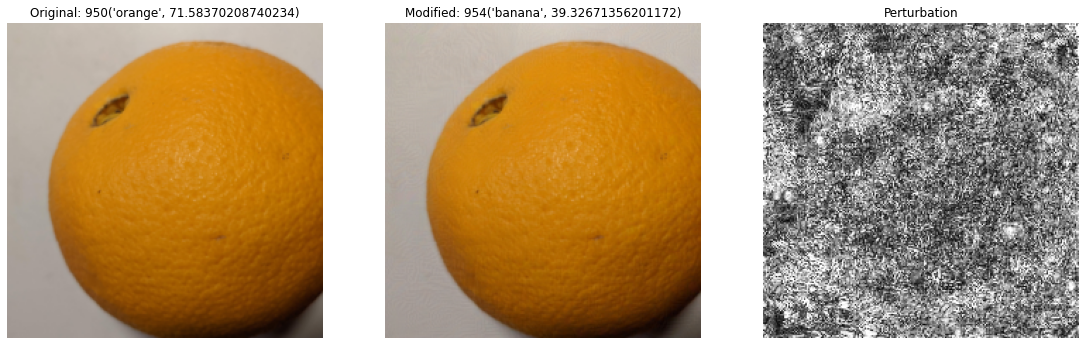

In [5]:


def func(inp, net=None, target=None):
    '''Computes negative log likelihood.'''
  
    out = net(inp)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))

    print(f"Loss: {loss.item()}")
    return loss



def attack(img, model, target, eps=1e-3, n_iter=50):
    '''Run the Fast Sign Gradient Method (FSGM) attack.'''

    img = img.detach().clone()

    orig_prediction = model(img).argmax()
    print(f"Original prediction: {orig_prediction.item()}")

    for i in range(n_iter):
        model.zero_grad()

        grad = compute_gradient(
                func, img, net=model, target=target.item()
                )
        img = torch.clamp(img - eps * grad.sign(), -2, 2)
        new_prediction = model(img).argmax()
        print("new prediction : ", new_prediction)

        if new_prediction == target:
            print(f"We fooled the network after {i} iterations!")
            print(f"New prediction: {new_prediction.item()}")
            break

    return img, orig_prediction.item(), new_prediction.item()


if __name__ == "__main__":
    model = models.alexnet(pretrained = True)
    
    model.eval()

    orig_img = read_image("Images/orange.jpg")
    
    classes, class2id = get_classes('imagenet.txt')
    
    orig_class = 'orange'
    target_class = 'banana'
    target_classid = class2id[target_class]
    target = torch.tensor([target_classid])

    perturbed_img, orig_prediction, new_prediction = attack(
            orig_img, model, target, eps=1e-3, n_iter=100
            )

    _, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))
    arr = to_array(orig_img)
    new_arr = to_array(perturbed_img)
    diff_arr = np.abs(arr - new_arr).mean(axis=-1)
    diff_arr = diff_arr / diff_arr.max()
    
    orig_img_confidence = predict_class(orig_img, model, classes)
    perturbed_img_confidence = predict_class(perturbed_img, model, classes)

    ax_orig.imshow(arr)
    ax_new.imshow(new_arr)
    ax_diff.imshow(diff_arr, cmap="gray")

    ax_orig.axis("off")
    ax_new.axis("off")
    ax_diff.axis("off")

    ax_orig.set_title(f"Original: {orig_prediction}{orig_img_confidence}")
    ax_new.set_title(f"Modified: {new_prediction}{perturbed_img_confidence}")
    ax_diff.set_title("Perturbation")

    plt.savefig("res_1.png")
